In [ ]:
import os
import sys
import random
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

import torchvision.transforms as T
import torchvision.datasets as dset
import torchvision.models as models

from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, classification_report, roc_curve


using_platform = 'kaggle'

dataset_path = None
if using_platform == 'colab':
    from google.colab import drive
    import kagglehub
    drive.mount('/content/drive')
    sys.path.append('/content/drive/My Drive/COMP4471/Project')
    dataset_path = kagglehub.dataset_download("jagachau/weather-dataset")
    dataset_path = os.path.join(dataset_path, 'weather_dataset')
elif using_platform == 'kaggle':
    dataset_path = '/kaggle/input/weather-dataset/weather_dataset'
else:
    print('invalid platform')

print('dataset path:', dataset_path)

seed = 4471
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# For precise error position
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device:', device)
print('GPU count:', torch.cuda.device_count())

dataset path: /kaggle/input/weather-dataset/weather_dataset
using device: cuda
GPU count: 1


Images count
hail      :  591
frost     :  475
rime      : 1160
fogsmog   :  851
cloudy    :  300
snow      :  621
sunrise   :  357
rain      :  973
glaze     :  639
lightning :  377
shine     :  253
sandstorm :  692
dew       :  698
Total: 13 classes with 7987 images


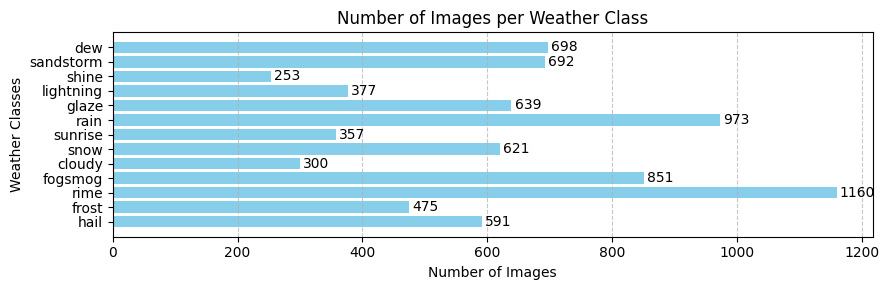

In [ ]:
classes = os.listdir(dataset_path)
num_classes = len(classes)

print("Images count")

total = 0
class_counts = []
for weather in classes:
	count = len(os.listdir(dataset_path+'/'+weather))
	total += count
	class_counts.append(count)
	print(f"{weather:9} : {count:4}")

print(f"Total: {num_classes} classes with {total} images")

plt.figure(figsize=(9, 3))  # Adjust width and height for a wider look
plt.barh(classes, class_counts, color='skyblue')  # Horizontal bars

# Labels and title
plt.xlabel('Number of Images')
plt.ylabel('Weather Classes')
plt.title('Number of Images per Weather Class')

# Add data labels to bars
for i, count in enumerate(class_counts):
	plt.text(count + 5, i, str(count), va='center', ha='left')  # Adjust placement

plt.grid(axis='x', linestyle='--', alpha=0.7)  # Grid for x-axis
plt.tight_layout()  # Adjust layout to prevent cutoff
plt.show()

In [ ]:
def split_dataset(altered_dataset, original_dataset, train_ratio=0.8, batch_size=64):
	workers = torch.cuda.device_count() * 2 if torch.cuda.device_count() else 1
	targets = np.array(altered_dataset.targets)

	# Split per class
	train_indices = []
	val_indices = []

	for class_idx in range(len(classes)):
		class_indices = np.where(targets == class_idx)[0]
		class_size = len(class_indices)

		train_size = int(train_ratio * class_size)

		# Use random_state for reproducibility
		train_idx, val_idx = train_test_split(
			class_indices,
			train_size=train_size,
			random_state=seed
		)

		train_indices.extend(train_idx)
		val_indices.extend(val_idx)

	train_dataset = Subset(altered_dataset, train_indices)
	val_dataset = Subset(original_dataset, val_indices)

	train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
	val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)

	print(f"Train set size: {len(train_dataset)}")
	print(f"Validation set size: {len(val_dataset)}")

	return train_loader, val_loader

In [4]:
resnet_mean = [0.485, 0.456, 0.406]
resnet_sd = [0.229, 0.224, 0.225]

transform_train = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15), 
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05), 
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    T.RandomResizedCrop(size=224, scale=(0.85, 1.0)), 
    T.ToTensor(),
    T.Normalize(mean=resnet_mean, std=resnet_sd)
])

transform_val = T.Compose([
    T.Resize((224, 224)), # for ResNet
    T.ToTensor(),
    T.Normalize(mean=resnet_mean, std=resnet_sd)
])

altered_dataset = dset.ImageFolder(root=dataset_path, transform=transform_train)
original_dataset = dset.ImageFolder(root=dataset_path, transform=transform_val)
print(original_dataset.classes)

train_loader, val_loader = split_dataset(altered_dataset, original_dataset, 0.8, 128)
all_loader = DataLoader(original_dataset, batch_size=64, shuffle=False, num_workers=2)

['cloudy', 'dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rime', 'sandstorm', 'shine', 'snow', 'sunrise']
Train set size: 6384
Validation set size: 1603


## Training

In [ ]:
def get_model():
	model = models.resnet152(weights='DEFAULT')

	num_features = model.fc.in_features
	model.fc = nn.Linear(num_features, num_classes)
	model.to(device)

	for param in model.parameters():
		param.requires_grad = False
		
	for param in model.layer4.parameters():
		param.requires_grad = True
	for param in model.layer3.parameters():
		param.requires_grad = True
	for param in model.fc.parameters():
		param.requires_grad = True

	return model

def train_model(model, train_loader, val_loader, optimizer, scheduler, epochs=10, criterion=nn.CrossEntropyLoss()):
	best_val_acc = 0
	best_model_state = None
		
	train_losses, val_losses = [], []
	train_accs, val_accs = [], []

	for e in range(epochs):
		# Training
		model.train()
		train_loss = 0.0
		correct = 0
		total = 0
		batch_bar = tqdm(train_loader, desc=f"Epoch {e+1}: Train")
		for x, y in batch_bar:        
		x, y = x.to(device), y.to(device)

		scores = model(x)
		loss = criterion(scores, y)
			
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		train_loss += loss.item()
		_, predicted = torch.max(scores, 1)
		total += y.size(0)
		correct += (predicted == y).sum().item()

		batch_acc = 100 * correct / total
		batch_bar.set_postfix({"Train loss": f"{train_loss/len(batch_bar):.4f}", "Train acc": f"{batch_acc:.2f}%"})


		scheduler.step()
		train_acc = 100 * correct / total
		train_accs.append(train_acc)
		avg_train_loss = train_loss / len(train_loader)
		train_losses.append(avg_train_loss)

		# Validation
		model.eval()
		val_loss = 0.0
		correct = 0
		total = 0
		with torch.no_grad():  # No gradients during validation
			batch_bar = tqdm(val_loader, desc=f"Epoch {e+1}: Validation")
			for x, y in batch_bar:
				x, y = x.to(device), y.to(device)
				scores = model(x)
				loss = criterion(scores, y)
				val_loss += loss.item()
				_, predicted = torch.max(scores, 1)
				total += y.size(0)
				correct += (predicted == y).sum().item()
				batch_acc = 100 * correct / total
				batch_bar.set_postfix({"Val loss": f"{val_loss/len(batch_bar):.4f}", "Val acc": f"{batch_acc:.2f}%"})

		val_acc = 100 * correct / total
		val_accs.append(val_acc)
		avg_val_loss = val_loss / len(val_loader)
		val_losses.append(avg_val_loss)

		# Save best model
		if val_acc > best_val_acc:
			best_val_acc = val_acc
			best_model_state = model.state_dict().copy()
			print(f"New best model saved with validation accuracy: {val_acc:.2f}%")

		# Load best model
	if best_model_state is not None:
		model.load_state_dict(best_model_state)
		print(f"Loaded best model with validation accuracy: {best_val_acc:.2f}%")
		
	return train_losses, val_losses, train_accs, val_accs

def loss_acc_plot(train_losses, val_losses, train_accs, val_accs):
    # Plot loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_accs) + 1), train_accs, label='Training Accuracy', marker='o')
    plt.plot(range(1, len(val_accs) + 1), val_accs, label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def inference(model, loader):
	model.eval()
	correct = 0
	total = 0
	with torch.no_grad():
		for inputs, labels in tqdm(loader, desc='Inference'):
			inputs, labels = inputs.to(device), labels.to(device)
			outputs = model(inputs)
			_, predicted = torch.max(outputs, 1)
			total += labels.size(0)
			correct += (predicted == labels).sum().item()
	test_acc = 100 * correct / total
	print(f"Accuracy: {test_acc:.2f}%")

def get_predictions_and_probs(model, loader):
	model.eval()
	all_labels, all_preds, all_probs = [], [], []
	with torch.no_grad():
		for inputs, labels in tqdm(loader, desc="Loading"):
			inputs, labels = inputs.to(device), labels.to(device)
			outputs = model(inputs)
			probs = torch.softmax(outputs, dim=1)
			_, preds = torch.max(probs, 1)
			all_labels.extend(labels.cpu().numpy())
			all_preds.extend(preds.cpu().numpy())
			all_probs.extend(probs.cpu().numpy())
	return np.array(all_labels), np.array(all_preds), np.array(all_probs)

def get_class_weights(class_counts):
    class_counts = np.array(class_counts)
    beta = 0.999
    effective_num = 1.0 - np.power(beta, class_counts)
    weights = (1.0 - beta) / effective_num
    weights = weights / weights.sum() * len(class_counts)
    return torch.tensor(weights, dtype=torch.float32, device=device)

## Without class weights

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 202MB/s] 
Epoch 1: Validation: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s, Val loss=0.4521, Val acc=85.90%]


New best model saved with validation accuracy: 85.90%


Epoch 2: Validation: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s, Val loss=0.3086, Val acc=90.14%]


New best model saved with validation accuracy: 90.14%


Epoch 3: Validation: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s, Val loss=0.2657, Val acc=91.52%]


New best model saved with validation accuracy: 91.52%


Epoch 4: Validation: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s, Val loss=0.2781, Val acc=91.58%]


New best model saved with validation accuracy: 91.58%


Epoch 5: Validation: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s, Val loss=0.2551, Val acc=92.45%]


New best model saved with validation accuracy: 92.45%


Epoch 20: Validation: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s, Val loss=0.3736, Val acc=92.45%]


Loaded best model with validation accuracy: 92.45%


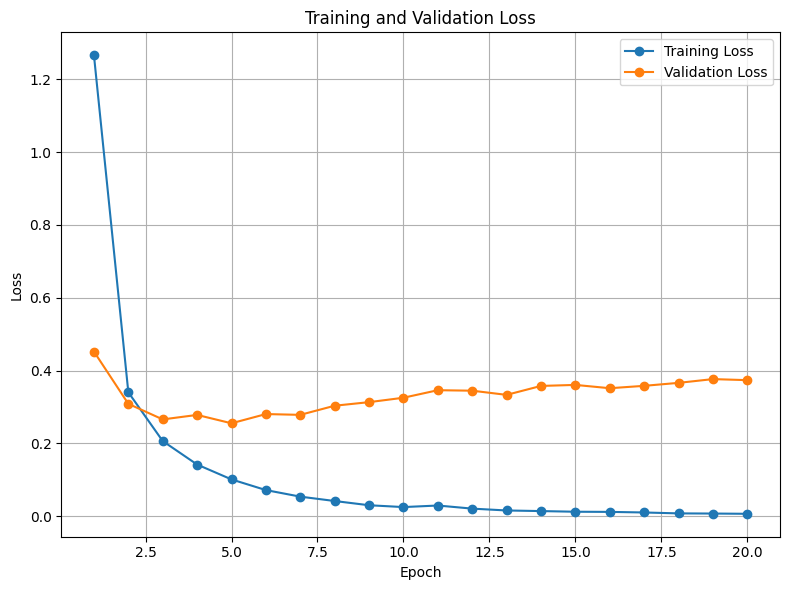

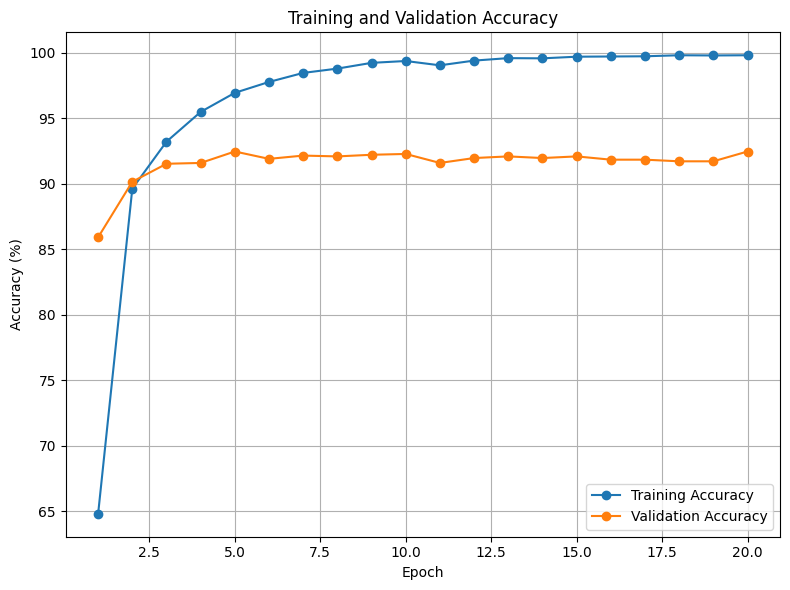

In [6]:
# Without class weights
epochs = 20
learning_rate = 5e-4

model1 = get_model()
optimizer = optim.Adam([
    {'params': model1.fc.parameters(), 'lr': learning_rate},
    {'params': model1.layer4.parameters(), 'lr': learning_rate/10},
    {'params': model1.layer3.parameters(), 'lr': learning_rate/20}
], weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

train_losses, val_losses, train_accs, val_accs = train_model(model1, train_loader, val_loader, optimizer, scheduler, epochs)

loss_acc_plot(train_losses, val_losses, train_accs, val_accs)

Loading: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


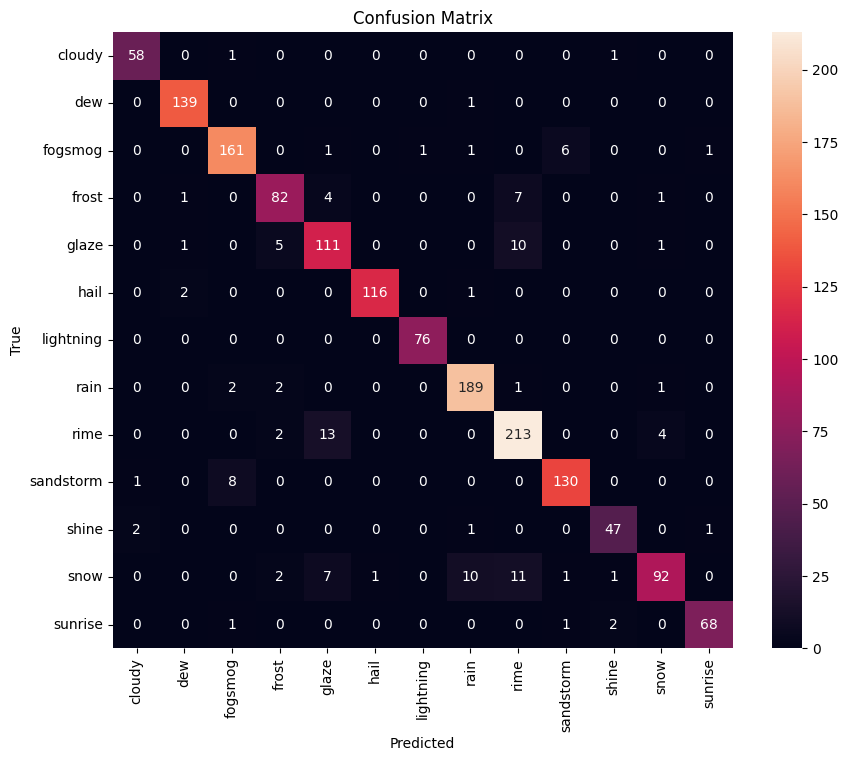

In [8]:
labels, preds, probs = get_predictions_and_probs(model1, val_loader)

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sb.heatmap(cm, annot=True, fmt='d', xticklabels=original_dataset.classes, yticklabels=original_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Precision and Recall:
Macro Precision: 0.9312
Macro Recall: 0.9254
Weighted Precision: 0.9253
Weighted Recall: 0.9245

Per-class Metrics:
              precision    recall  f1-score   support

      cloudy       0.95      0.97      0.96        60
         dew       0.97      0.99      0.98       140
     fogsmog       0.93      0.94      0.94       171
       frost       0.88      0.86      0.87        95
       glaze       0.82      0.87      0.84       128
        hail       0.99      0.97      0.98       119
   lightning       0.99      1.00      0.99        76
        rain       0.93      0.97      0.95       195
        rime       0.88      0.92      0.90       232
   sandstorm       0.94      0.94      0.94       139
       shine       0.92      0.92      0.92        51
        snow       0.93      0.74      0.82       125
     sunrise       0.97      0.94      0.96        72

    accuracy                           0.92      1603
   macro avg       0.93      0.93      0.93      1

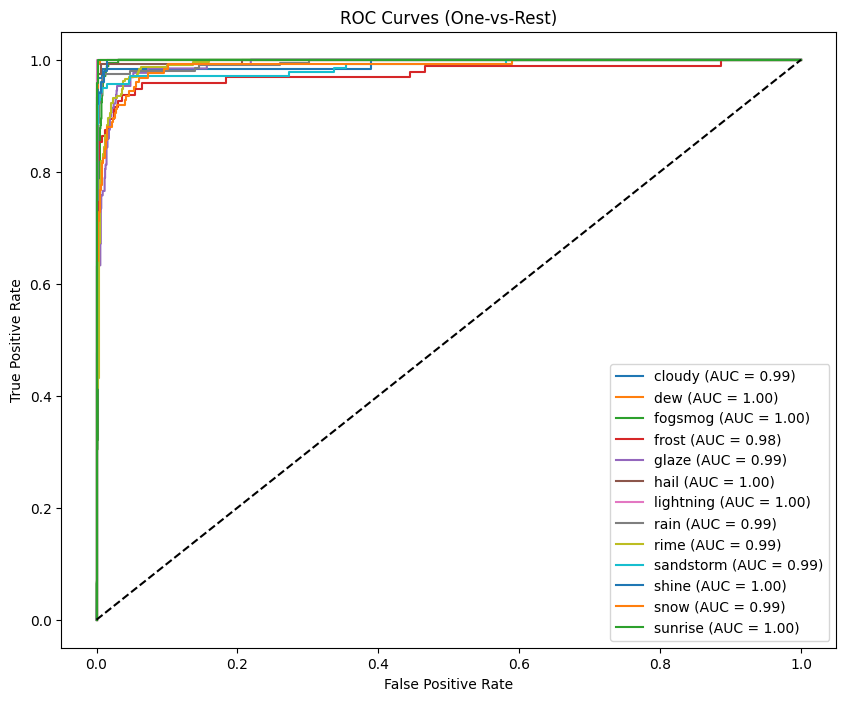

In [10]:
# Precision and Recall
print("Precision and Recall:")
print(f"Macro Precision: {precision_score(labels, preds, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(labels, preds, average='macro'):.4f}")
print(f"Weighted Precision: {precision_score(labels, preds, average='weighted'):.4f}")
print(f"Weighted Recall: {recall_score(labels, preds, average='weighted'):.4f}")
print("\nPer-class Metrics:")
print(classification_report(labels, preds, target_names=original_dataset.classes))

# AUC
labels_bin = label_binarize(labels, classes=range(num_classes))
auc_per_class = [roc_auc_score(labels_bin[:, i], probs[:, i]) for i in range(num_classes)]
macro_auc = roc_auc_score(labels_bin, probs, average='macro', multi_class='ovr')
micro_auc = roc_auc_score(labels_bin.ravel(), probs.ravel())

print("\nAUC Scores:")
for i, auc in enumerate(auc_per_class):
    print(f"AUC for {original_dataset.classes[i]}: {auc:.4f}")
print(f"Macro-average AUC: {macro_auc:.4f}")
print(f"Micro-average AUC: {micro_auc:.4f}")

# ROC Curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(labels_bin[:, i], probs[:, i])
    plt.plot(fpr, tpr, label=f'{original_dataset.classes[i]} (AUC = {auc_per_class[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='best')
plt.show()

## With class weights

Epoch 1: Validation: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s, Val loss=0.3310, Val acc=88.71%]


New best model saved with validation accuracy: 88.71%


Epoch 2: Validation: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s, Val loss=0.2516, Val acc=91.02%]


New best model saved with validation accuracy: 91.02%


Epoch 3: Validation: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s, Val loss=0.2793, Val acc=91.08%]


New best model saved with validation accuracy: 91.08%


Epoch 4: Validation: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s, Val loss=0.2680, Val acc=91.52%]


New best model saved with validation accuracy: 91.52%


Epoch 5: Validation: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s, Val loss=0.2856, Val acc=91.70%]


New best model saved with validation accuracy: 91.70%


Epoch 6: Validation: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s, Val loss=0.3128, Val acc=92.01%]


New best model saved with validation accuracy: 92.01%


Epoch 9: Validation: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s, Val loss=0.3066, Val acc=92.45%]


New best model saved with validation accuracy: 92.45%


Epoch 12: Validation: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s, Val loss=0.3407, Val acc=92.64%]


New best model saved with validation accuracy: 92.64%


Epoch 13: Validation: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s, Val loss=0.3324, Val acc=92.70%]


New best model saved with validation accuracy: 92.70%


Epoch 22: Validation: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s, Val loss=0.3749, Val acc=92.76%]


New best model saved with validation accuracy: 92.76%


Epoch 24: Validation: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s, Val loss=0.3718, Val acc=92.95%]


New best model saved with validation accuracy: 92.95%


Epoch 29: Validation: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s, Val loss=0.3887, Val acc=93.01%]


New best model saved with validation accuracy: 93.01%


Epoch 30: Validation: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s, Val loss=0.3769, Val acc=93.08%]


New best model saved with validation accuracy: 93.08%
Loaded best model with validation accuracy: 93.08%


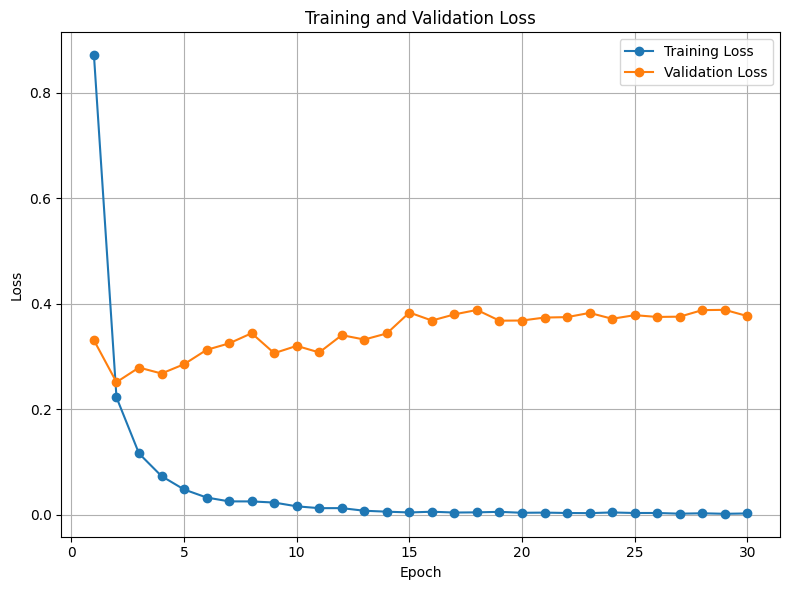

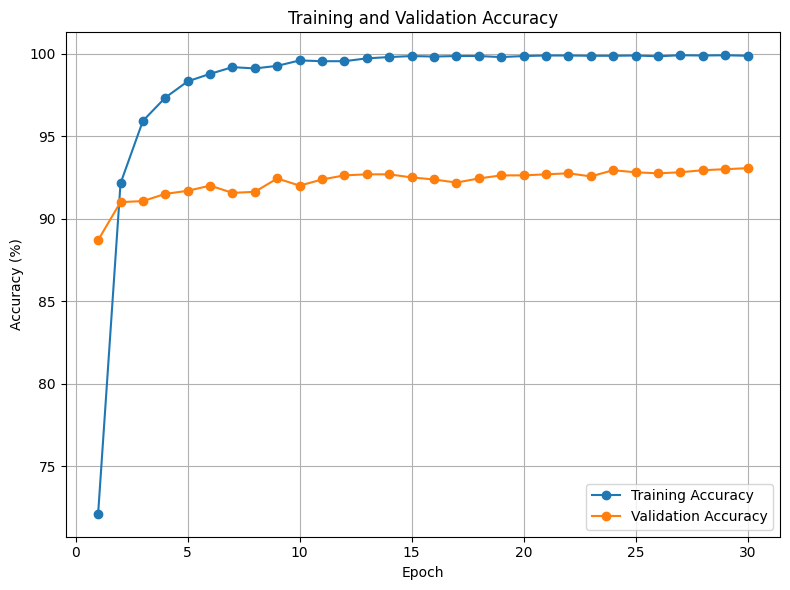

In [12]:
epochs = 30
learning_rate = 1e-3

model2 = get_model()
optimizer = optim.Adam([
    {'params': model2.fc.parameters(), 'lr': learning_rate},
    {'params': model2.layer4.parameters(), 'lr': learning_rate/10},
    {'params': model2.layer3.parameters(), 'lr': learning_rate/20}
], weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)

class_weights = get_class_weights(class_counts)
criterion = nn.CrossEntropyLoss(weight=class_weights)

train_losses, val_losses, train_accs, val_accs = train_model(model2, train_loader, val_loader, optimizer, scheduler, epochs, criterion)

loss_acc_plot(train_losses, val_losses, train_accs, val_accs)

Loading: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


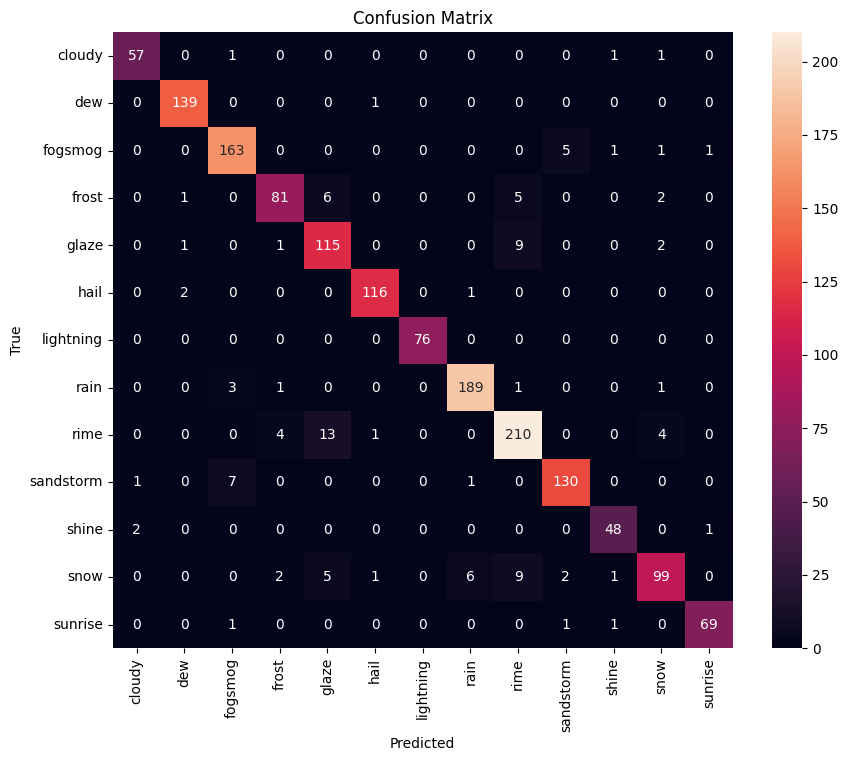

In [13]:
labels, preds, probs = get_predictions_and_probs(model2, val_loader)

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sb.heatmap(cm, annot=True, fmt='d', xticklabels=original_dataset.classes, yticklabels=original_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Precision and Recall:
Macro Precision: 0.9353
Macro Recall: 0.9325
Weighted Precision: 0.9311
Weighted Recall: 0.9308

Per-class Metrics:
              precision    recall  f1-score   support

      cloudy       0.95      0.95      0.95        60
         dew       0.97      0.99      0.98       140
     fogsmog       0.93      0.95      0.94       171
       frost       0.91      0.85      0.88        95
       glaze       0.83      0.90      0.86       128
        hail       0.97      0.97      0.97       119
   lightning       1.00      1.00      1.00        76
        rain       0.96      0.97      0.96       195
        rime       0.90      0.91      0.90       232
   sandstorm       0.94      0.94      0.94       139
       shine       0.92      0.94      0.93        51
        snow       0.90      0.79      0.84       125
     sunrise       0.97      0.96      0.97        72

    accuracy                           0.93      1603
   macro avg       0.94      0.93      0.93      1

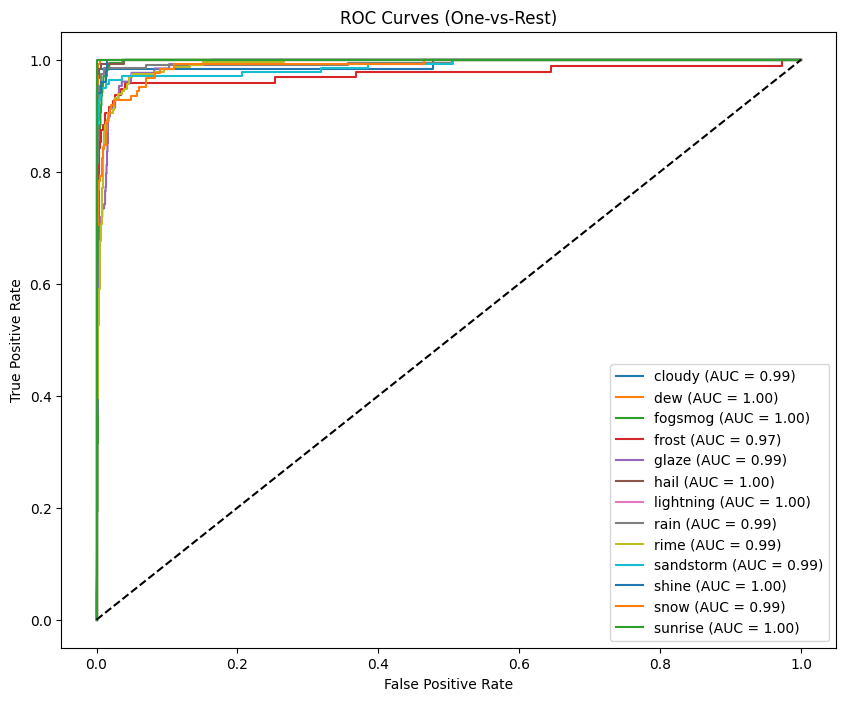

In [15]:
# Precision and Recall
print("Precision and Recall:")
print(f"Macro Precision: {precision_score(labels, preds, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(labels, preds, average='macro'):.4f}")
print(f"Weighted Precision: {precision_score(labels, preds, average='weighted'):.4f}")
print(f"Weighted Recall: {recall_score(labels, preds, average='weighted'):.4f}")
print("\nPer-class Metrics:")
print(classification_report(labels, preds, target_names=original_dataset.classes))

# AUC
labels_bin = label_binarize(labels, classes=range(num_classes))
auc_per_class = [roc_auc_score(labels_bin[:, i], probs[:, i]) for i in range(num_classes)]
macro_auc = roc_auc_score(labels_bin, probs, average='macro', multi_class='ovr')
micro_auc = roc_auc_score(labels_bin.ravel(), probs.ravel())

print("\nAUC Scores:")
for i, auc in enumerate(auc_per_class):
    print(f"AUC for {original_dataset.classes[i]}: {auc:.4f}")
print(f"Macro-average AUC: {macro_auc:.4f}")
print(f"Micro-average AUC: {micro_auc:.4f}")

# ROC Curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(labels_bin[:, i], probs[:, i])
    plt.plot(fpr, tpr, label=f'{original_dataset.classes[i]} (AUC = {auc_per_class[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='best')
plt.show()

In [ ]:
torch.save(model2, '/kaggle/working/single_cnn_model.pth')